- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- Remove the eclipsing binary signal (using periodic window) and model the rest of the signal
- From the simulations

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

# Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import clip_windows
import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
#df = pd.read_csv("data/sim_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df = pd.read_csv("data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

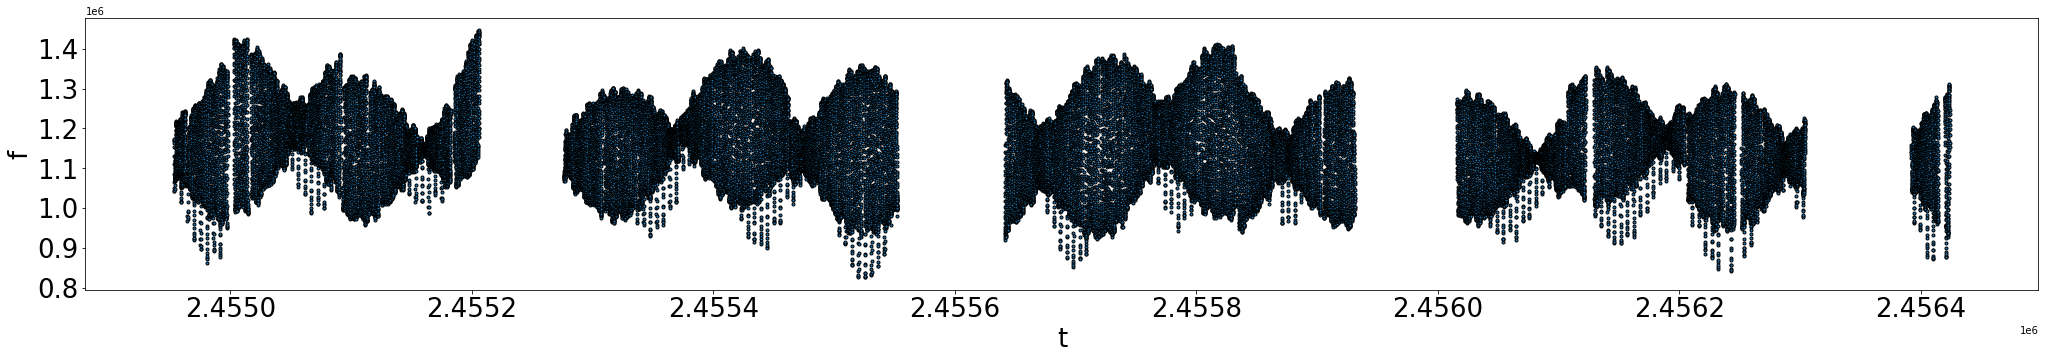

In [6]:
plotter.plot_data(X, Y)

array([0.        , 0.5673045 , 0.56716849, 0.56744051, 0.56703248])

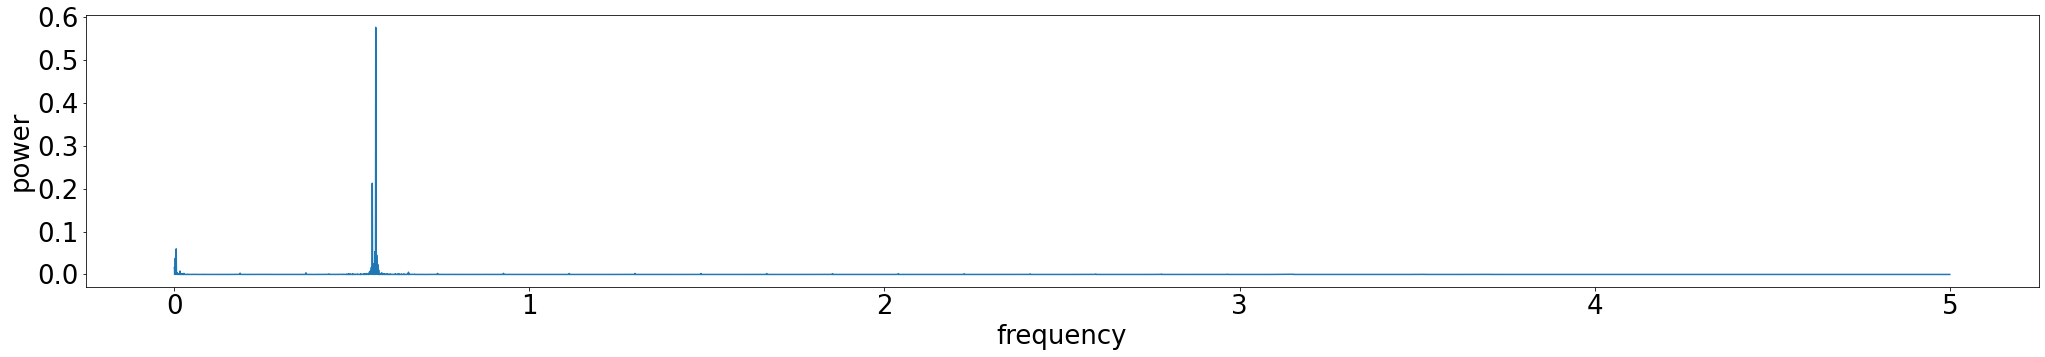

In [7]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [8]:
# 11300 is the complete first envelope
N_part=11300

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

In [10]:
# normalize the data
_, _, Y_part = experiment_util.normalize_mean(Y_part)

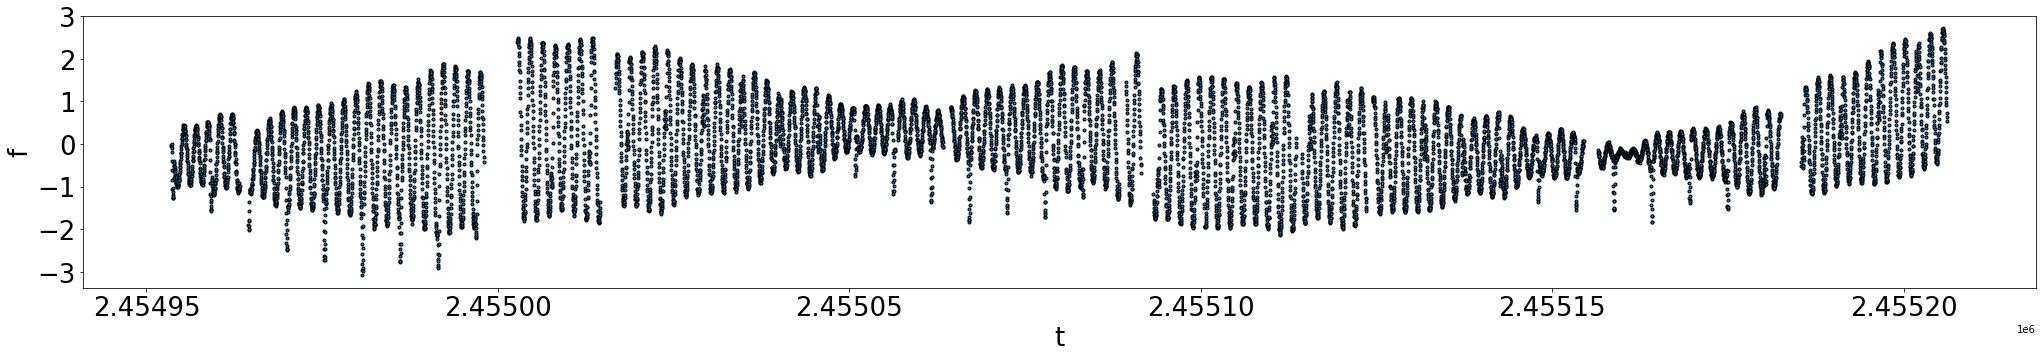

In [11]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [12]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+4) * sample_period
first_sec_eclipse_date = X_part[0] + (+265) * sample_period
eclipse_period=10.790492 # todo: uncertainty

window_size = 25  # todo: window size in duration
eclipse_duration = window_size * sample_period
X_part_window, Y_part_window = clip_windows.clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

In [13]:
# We have all timestamps with observations in X_part
# X_part_window is X_part minus the masked out eclipses
# If we want to plot the mask, subtract X_part_window from X_part and assume
# observations of amplitude 1 at those timestamps
a=X_part
b=X_part_window
X_mask=a
Y_mask=np.zeros(shape=Y_part.shape)
X_mask_idcs=np.searchsorted(a, np.setdiff1d(a, b))
Y_mask[X_mask_idcs]=1

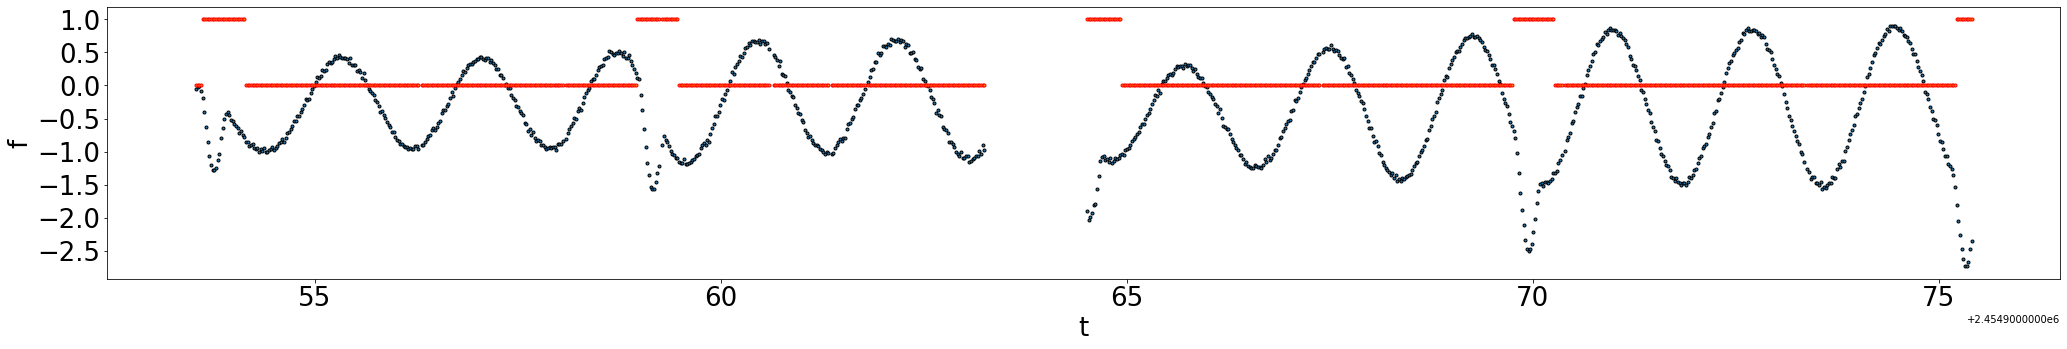

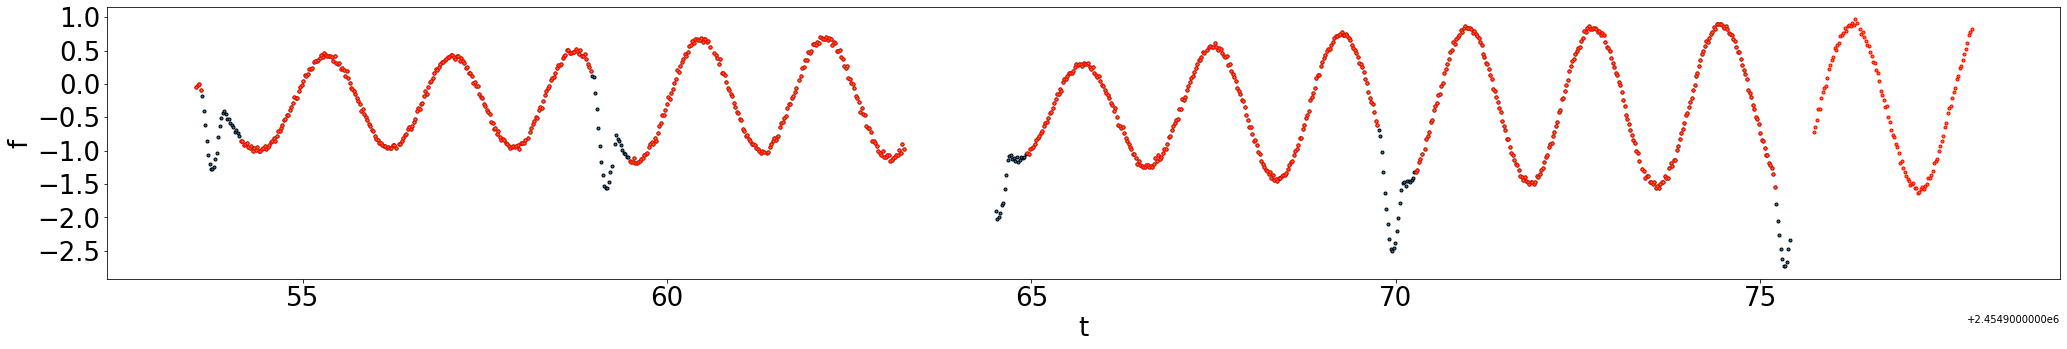

In [14]:
# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]
plotter.plot_data(X_part[:1000], Y_part[:1000], X_part[:1000], Y_mask[:1000])
plotter.plot_data(X_part[:1000], Y_part[:1000], X_without_gaps[:1000], Y_without_gaps[:1000])
#plotter.plot_data(X_part, Y_part, X_part, Y_mask)
#plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

In [15]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)
X_part_window=torch.tensor(X_part_window)
Y_part_window=torch.tensor(Y_part_window)

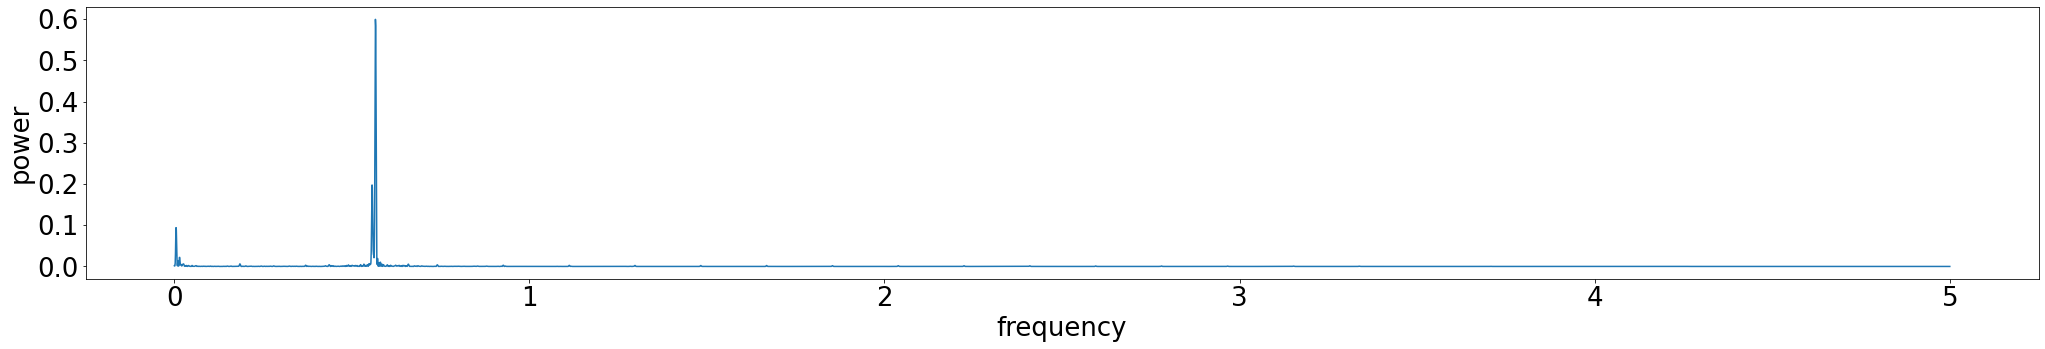

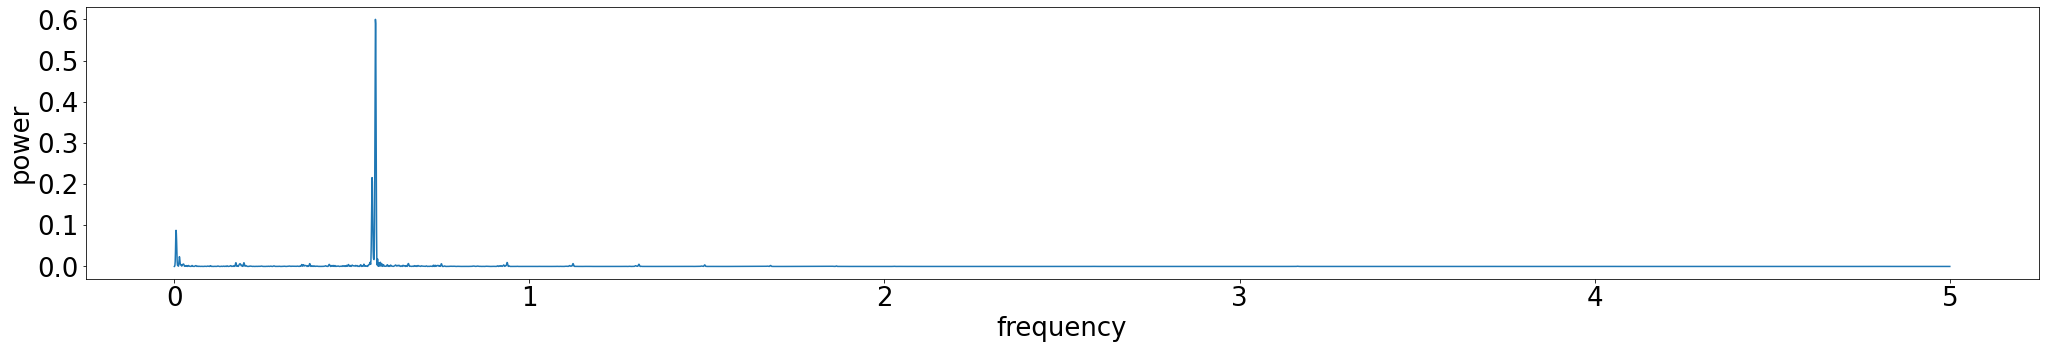

In [16]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

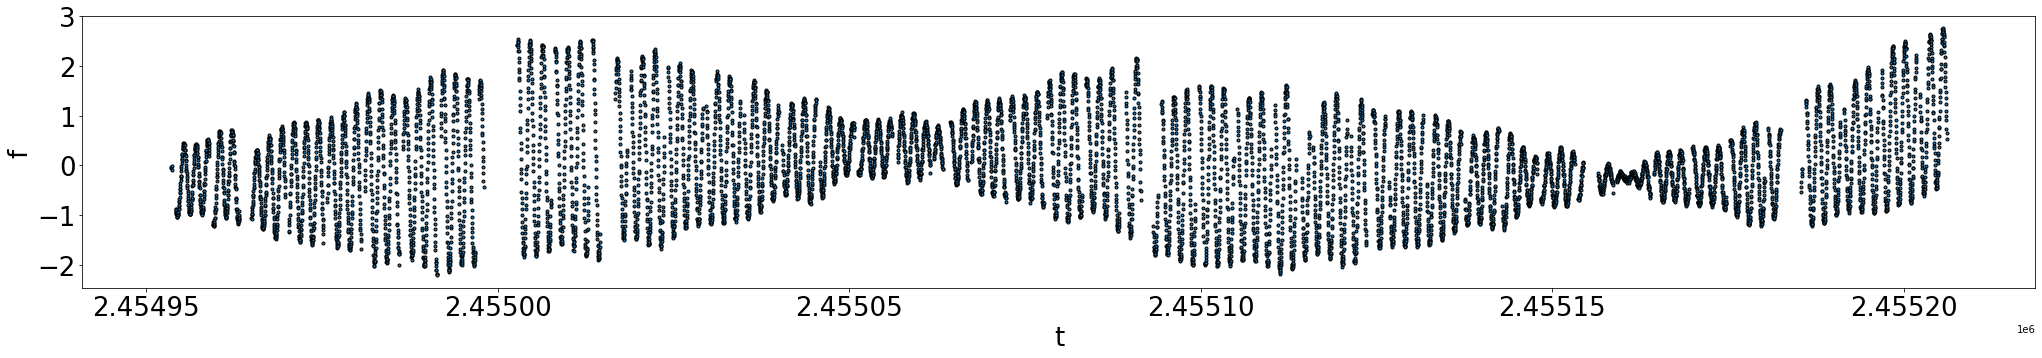

In [17]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
_, _, Y_part = experiment_util.normalize_mean(Y_part)
plotter.plot_data(X_part_window, Y_part_window)

Move data and models to the GPU

In [18]:
if USE_CUDA:
    X_part_window = X_part_window.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part_window = Y_part_window.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [19]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel 1
        sho1 = gpytorch.kernels.PeriodicKernel()
        sho1.period_length = 1/0.5673
        sho1.lengthscale = 0.001
        # Periodic kernel 2
        sho2 = gpytorch.kernels.PeriodicKernel()
        sho2.period_length = 1/0.5575
        sho2.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()

        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(sho1),
            gpytorch.kernels.ScaleKernel(sho2),
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part_window, Y_part_window, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [20]:
training_iter = 50

# NOTE: you can not run this with 100 iterations as it will have large spikes
# in the gaps due to the length scale becoming very large
# TODO: should we set a prior on the length scale, with minimum length?

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part_window)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part_window)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Lengthscale: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
#        model.covar_module.base_kernel.lengthscale,
        0,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.860   Lengthscale: 0.000    noise: 0.693
Iter 2/50 - Loss: 1.014   Lengthscale: 0.000    noise: 0.621
Iter 3/50 - Loss: 0.896   Lengthscale: 0.000    noise: 0.555
Iter 4/50 - Loss: 0.790   Lengthscale: 0.000    noise: 0.494
Iter 5/50 - Loss: 0.696   Lengthscale: 0.000    noise: 0.438
Iter 6/50 - Loss: 0.622   Lengthscale: 0.000    noise: 0.387
Iter 7/50 - Loss: 0.549   Lengthscale: 0.000    noise: 0.341
Iter 8/50 - Loss: 0.484   Lengthscale: 0.000    noise: 0.299
Iter 9/50 - Loss: 0.424   Lengthscale: 0.000    noise: 0.262
Iter 10/50 - Loss: 0.361   Lengthscale: 0.000    noise: 0.229
Iter 11/50 - Loss: 0.293   Lengthscale: 0.000    noise: 0.199
Iter 12/50 - Loss: 0.229   Lengthscale: 0.000    noise: 0.173
Iter 13/50 - Loss: 0.166   Lengthscale: 0.000    noise: 0.150
Iter 14/50 - Loss: 0.097   Lengthscale: 0.000    noise: 0.130
Iter 15/50 - Loss: 0.034   Lengthscale: 0.000    noise: 0.113
Iter 16/50 - Loss: -0.034   Lengthscale: 0.000    noise: 0.097
Iter 17/50 - Los

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

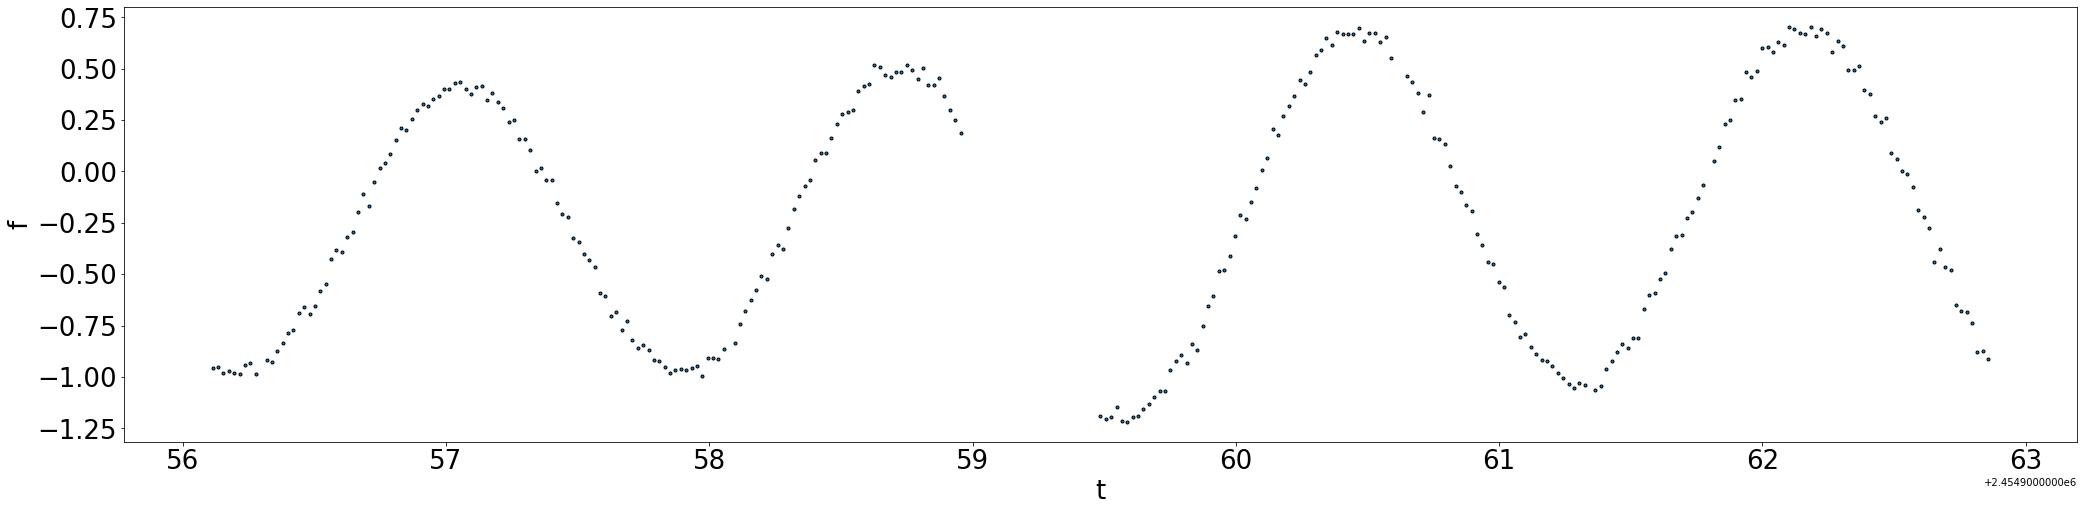

In [22]:
plotter.plot_series(X_part_window.cpu().numpy()[100:400], Y_part_window.cpu().numpy()[100:400])

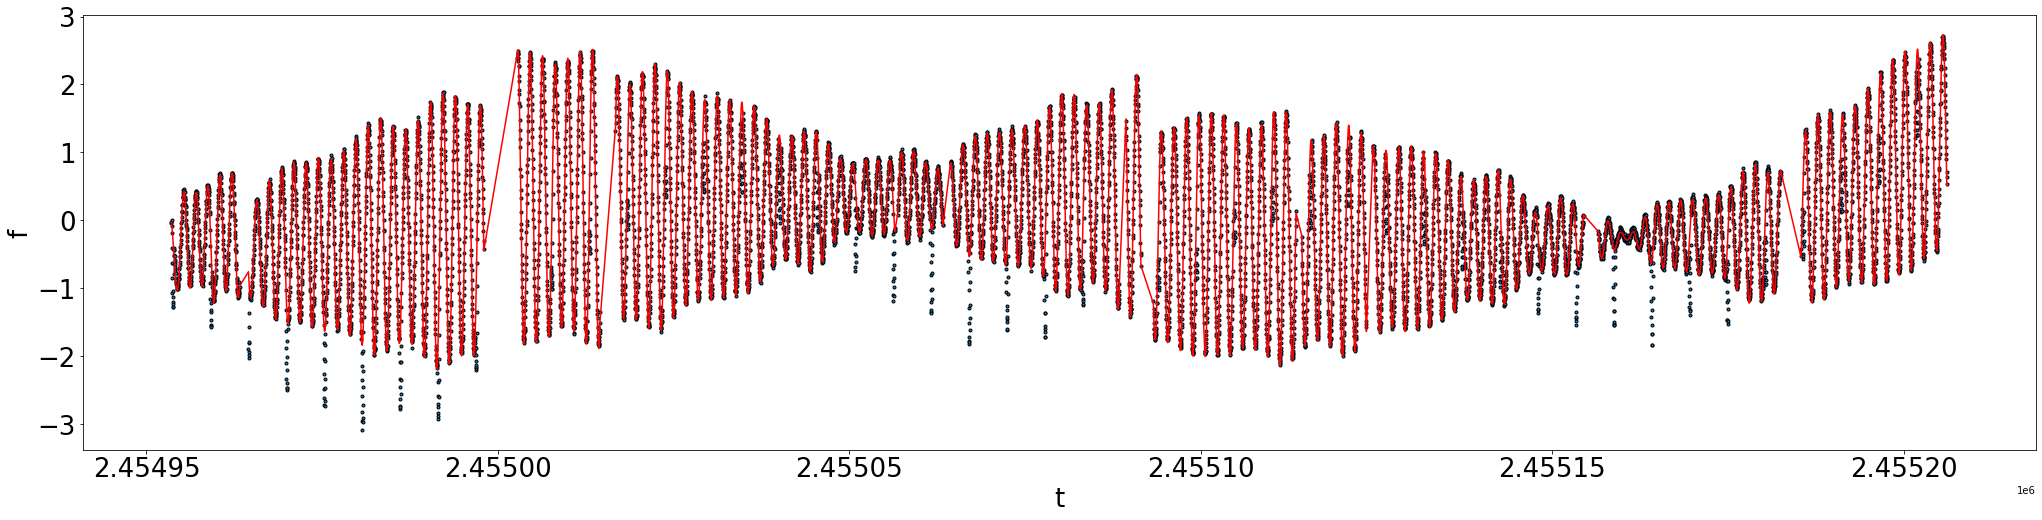

In [29]:
# Predict on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))
    plotter.plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

# Correlation between the pulsation+noise data and the full data with E.B. removed

In [24]:
df = pd.read_csv("./data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
X_orig_pulse, Y_orig_pulse = df['Time'].tolist(), df['Lc'].tolist()
X_orig_pulse, Y_orig_pulse = np.array(X_orig_pulse), np.array(Y_orig_pulse)
X_orig_pulse = X_orig_pulse[:N_part]
Y_orig_pulse = Y_orig_pulse[:N_part]

In [25]:
# normalize the data, using the same formula as for the full signal!
_, _, Y_orig_pulse = experiment_util.normalize_mean(Y_orig_pulse)

In [26]:
experiment_util.calculate_error(Y_orig_pulse, Y_part_pred.mean.cpu().numpy())

TimeSeriesSimilarity(correlation=0.9994657175666143, rmse=0.04691889425705617)

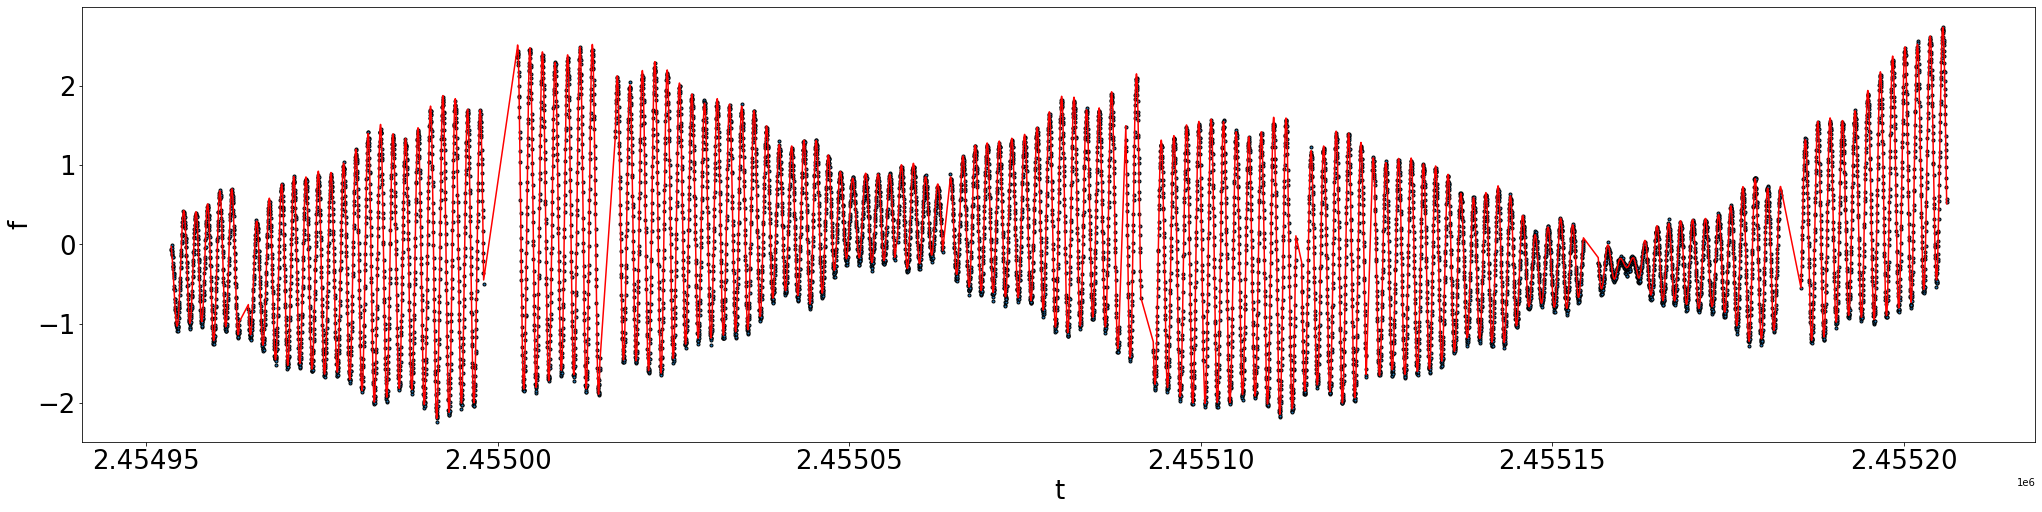

In [27]:
# Now plot our processed lightcurve over the artificial pulse only lightcurve. They should be the same!
plotter.plot_series(X_orig_pulse, Y_orig_pulse, X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

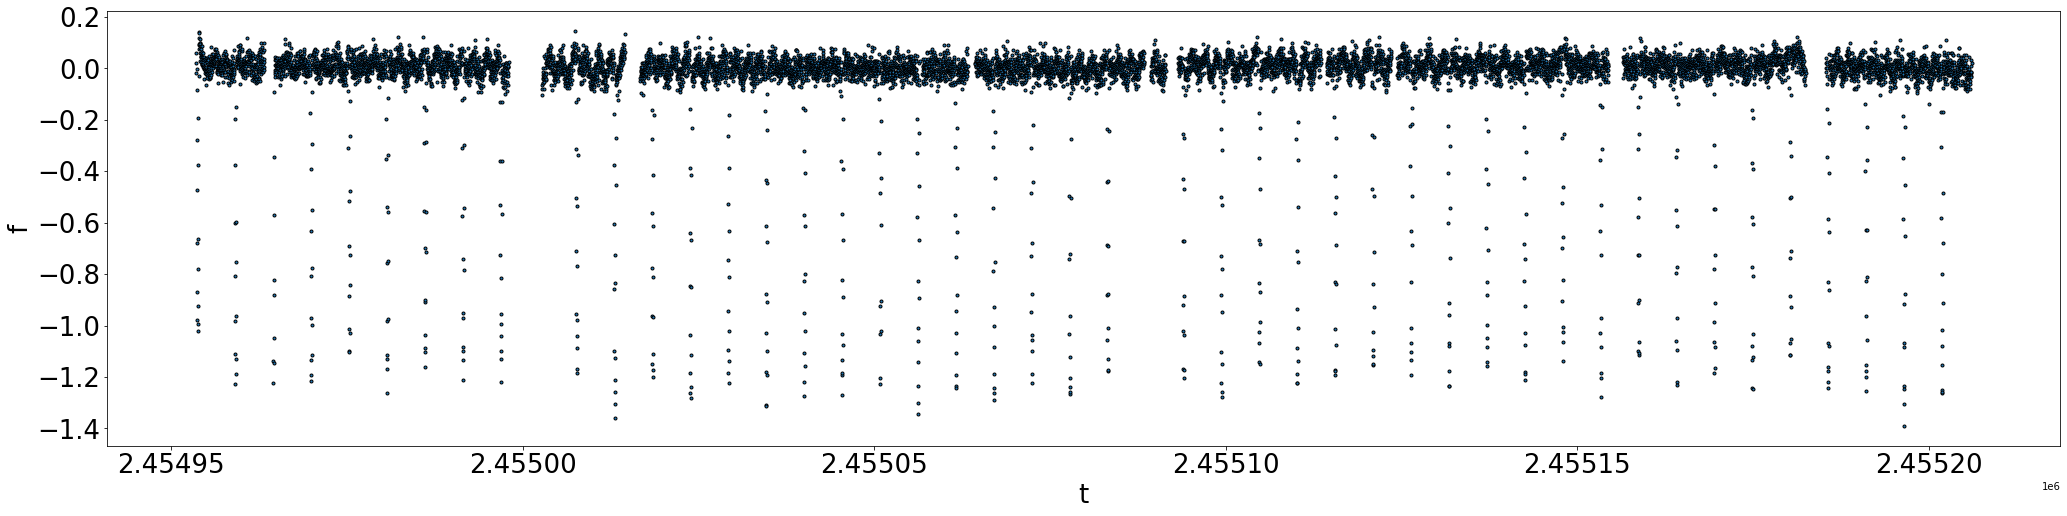

In [28]:
# Subtract the model pulsation signal from the full signal. This should give us the eclipses only, ideally with no noise!
plotter.plot_series(X_part, Y_part - Y_part_pred.mean.cpu().numpy())